# Analize weather data from my handmade weatherstation

##### Подгружаем основные библиотеки для работы с данным
##### Настраиваем отображение графиков и отключаем вывод предупреждений

In [10]:
# import libraries
%load_ext autoreload
%autoreload 2

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

from libs.pd_names import names as names
from libs.myutils import temp_eff as te
from libs.myutils import freezing as fz
from libs.myutils import dew_point as dp

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
colors = ['black', 'silver', 'firebrick', 'sandybrown', 'gold', 'olivedrab',
          'chartreuse', 'green', 'cyan', 'darkblue', 'coral', 'orange',
          'yellow', 'red', 'greenyellow', 'steelblue']

In [87]:
# load data and preprocessing
# index_col = 'date', parse_date=True при открытии указываем, 
# что индексом является дата записи и необходимо распарсить дату
%time ds = pd.read_csv('data/weather_2018.csv', names=names[:-1]+['day'], sep='\t').iloc[1:,:]
ds = ds.dropna()

CPU times: user 4.55 s, sys: 878 ms, total: 5.43 s
Wall time: 6.58 s


##### Преобразуем столбец date к типу datetime64
###### Устанавливаем date  в качестве index
###### Данные хранятся в raw формате:
###### - все показатели целочисленные:
###### - температура уличная  (два десятичных знака, градусы Цельсия)
###### - влажность  (два десятичных знака, %)
###### - давление  (один десятичный знак, мм.рт.ст.)
###### - освещенность  (целое число 0 - 65534, Люксы)
###### - температура в помещении  (два десятичных знака, градусы Цельсия)
###### - напряжение питания модуля  (3 десятичных знака, миллиВольты)
###### - радиационный фон  (целое число, мкР/час)
###### - датчик широкого спектра газов  (целое число, 0 - 1024 бит)
###### - датчик инфракрасного излучения  (целое число, 0 - 1024 бит)
###### - датчик скорости ветра  (два десятичных знака, м/с)

In [88]:
ds.date = ds.date.astype('datetime64')
ds['month'] = ds.date.dt.month
ds['hour'] = ds.date.dt.hour
ds['wday'] = ds.date.dt.weekday
ds.set_index('date', inplace=True)
ds.tout = ds.tout*0.01
ds.hout = ds.hout*0.01
ds.pout = ds.pout*0.1
ds.tin = ds.tin*0.01
ds.wind_cur = ds.wind_cur*0.01
ds = ds[ds.uR > 0]
ds = ds[ds.wind_cur >= 0]
ds= ds[(ds.pout < 820) & (ds.pout > 650)]

##### Преобразуем дни месяца и часы к целочисленному виду
##### Декодируем значения дней недели в привычные имена

In [89]:
ds['month'] = ds.month.map({
    1.0:'january', 2.0:'february', 3.0:'march', 4.0:'april',
    5.0:'may', 6.0:'june', 7.0:'july', 8.0:'august', 
    9.0:'september', 10.0:'october', 11.0:'november', 12.0:'december'
})
ds['hour'] = ds.hour.map(int)
ds['wday'] = ds.wday.map({0.0:'monday', 1.0:'tuesday', 
                            2.0:'wednesday', 3.0:'thursday',
                            4.0:'friday', 5.0:'saturday', 6.0:'sunday'})

##### Добавляем столбцы "точка росы", "эффективная температура" и "дефицит точки росы"

In [90]:
ds['dew_point'] = dp(ds.tout, ds.hout)

In [91]:
ds['temp_eff'] = temp_eff(ds.tout, ds.hout, ds.wind_cur, lux=0)

In [92]:
ds['dif_dew_point'] = ds.tout - ds.dew_point

In [93]:
ds.head()

,tout,hout,pout,lout,tin,vcc,uR,mq2,infrared,wind_cur,day,month,hour,wday,dew_point,temp_eff,dif_dew_point
date,,,,,,,,,,,,,,,,,
2018-01-01 00:00:29,1.7,99.9,747.4,0,23.25,4957.0,23.0,183,-1.0,0.0,2018-01-01,january,0,monday,1.825155,-4.949332,-0.125155
2018-01-01 00:00:50,1.7,99.9,747.4,0,23.25,4913.0,16.0,183,-1.0,0.0,2018-01-01,january,0,monday,1.825155,-4.949332,-0.125155
2018-01-01 00:01:11,1.8,99.9,747.4,0,23.25,4957.0,28.0,184,-1.0,0.0,2018-01-01,january,0,monday,1.925260,-4.866573,-0.125260
2018-01-01 00:01:32,1.7,99.9,747.4,0,23.25,4957.0,12.0,184,-1.0,0.0,2018-01-01,january,0,monday,1.825155,-4.949332,-0.125155
2018-01-01 00:01:53,1.7,99.9,747.4,0,23.25,4935.0,13.0,184,-1.0,0.0,2018-01-01,january,0,monday,1.825155,-4.949332,-0.125155


In [20]:
sns.set(style='white', context='notebook', palette='deep')

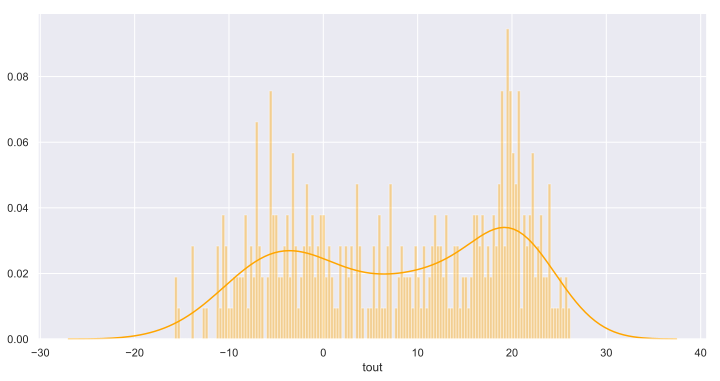

In [95]:
sns.set(rc={'figure.figsize':(12, 6)})
#sns.lmplot('dew_point', 'dif_dew_point', data=mean_by_day)
sns.distplot(ds.resample('1d').mean().tout, bins=int(ds.shape[0]/10000), color='orange')
#sns.lineplot(x='day', y='dif_dew_point', data=mean_by_day)


In [105]:
ds_by_weekday = ds.groupby('wday')

In [127]:
ds['2018 09:00:00':'2018 15:00:00'].head()

,tout,hout,pout,lout,tin,vcc,uR,mq2,infrared,wind_cur,day,month,hour,wday,dew_point,temp_eff,dif_dew_point
date,,,,,,,,,,,,,,,,,
2018-01-01 09:00:15,1.1,99.9,748.0,47,23.37,4935.0,20.0,179,-1.0,0.0,2018-01-01,january,9,monday,1.224529,-5.448155,-0.124529
2018-01-01 09:00:36,1.1,99.9,748.0,47,23.31,4913.0,23.0,179,-1.0,0.0,2018-01-01,january,9,monday,1.224529,-5.448155,-0.124529
2018-01-01 09:00:57,1.1,99.9,748.0,47,23.37,4935.0,11.0,179,-1.0,0.0,2018-01-01,january,9,monday,1.224529,-5.448155,-0.124529
2018-01-01 09:01:18,1.1,99.9,748.0,49,23.37,4913.0,28.0,179,-1.0,0.0,2018-01-01,january,9,monday,1.224529,-5.448155,-0.124529
2018-01-01 09:01:39,1.1,99.9,748.0,51,23.37,4935.0,20.0,179,-1.0,0.0,2018-01-01,january,9,monday,1.224529,-5.448155,-0.124529


#### График среднедневной температуры за год
##### Виджетом можно выбрать количество дней для усреднения

In [22]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [29]:
def agg_plot(days_for_mean=1):
    # аггрегируем данные за определенный период
    days_mean = ds.resample('%dD' % days_for_mean).mean()
    # настраиваем нужное заполнение для пропущенных значений
    # выбираем кубическую интерполяцию между отсутствуюищими данными
    days_mean.interpolate(method='cubic', inplace=True)
    # отрисовываем график среднедневной температуры за год с заполнением отсутствующих значений
    days_mean.tout.plot(color='green')

In [30]:
interact(agg_plot, days_for_mean=range(1, 25));

interactive(children=(Dropdown(description='days_for_mean', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [31]:
# функция поиска температуры в 13 и в 21 час
def t13_t21(mas):
    # паттерны для поиска нужной температуры
    patterns = [r'(\d{4}-\d{2}-\d{2} 13:\d{2}:\d{2})', r'(\d{4}-\d{2}-\d{2} 21:\d{2}:\d{2})']
    # извлекаем температуру в 13 часов и в 21 час дня для вычисления вероятности заморозка
    # преобразуем все даты в строку
    dates_str = ';'.join(mas.date)
    # применяем паттерны с нужным временем к строкам и формируем список нужных дат
    white_list_temp = [re.search(pattern, dates_str).group() for pattern in patterns]
    # извлекаем необходимые температуры
    m13 = mas.tout[mas.date == white_list_temp[0]].item()
    m21 = mas.tout[mas.date == white_list_temp[1]].item()
    return (m13, m21)

In [32]:
# fz(t13, t21)
# возвращает кортеж 0 - строковое описание вероятности, 1 - числовое описание вероятности или False, если расчет
# невозможен или True если темпераутра уже меньше нуля
# пример ('Too warm!', False)

In [33]:
days_below_zero = ds.groupby('day', as_index=False).agg({'tout':'min',
                                                        'hout':'mean',
                                                        'pout':'mean',
                                                        'lout':'mean', 
                                                        'temp_eff':'mean', 
                                                        'dew_point':'mean'})

In [34]:
days_below_zero['freez'] = days_below_zero.tout <= 0

In [35]:
days_below_zero.head()

,day,tout,hout,pout,lout,temp_eff,dew_point,freez
0,2018-01-01,-0.3,99.900000,747.819232,336.149717,-5.296764,1.407717,True
1,2018-01-02,1.7,99.900000,748.141481,132.687160,-4.270081,2.651897,False
2,2018-01-03,1.5,99.900000,749.542287,136.477082,-4.244431,2.685354,False
3,2018-01-04,0.0,99.676058,747.484941,380.933317,-5.139314,1.563073,True
4,2018-01-05,-2.2,99.900000,746.748105,126.743622,-7.509703,-1.209909,True


In [36]:
days_below_zero.groupby('freez').freez.count()

freez
False    222
True     136
Name: freez, dtype: int64

In [37]:
X = days_below_zero[['tout', 'hout', 'pout', 'lout', 'dew_point']]
y = days_below_zero.freez

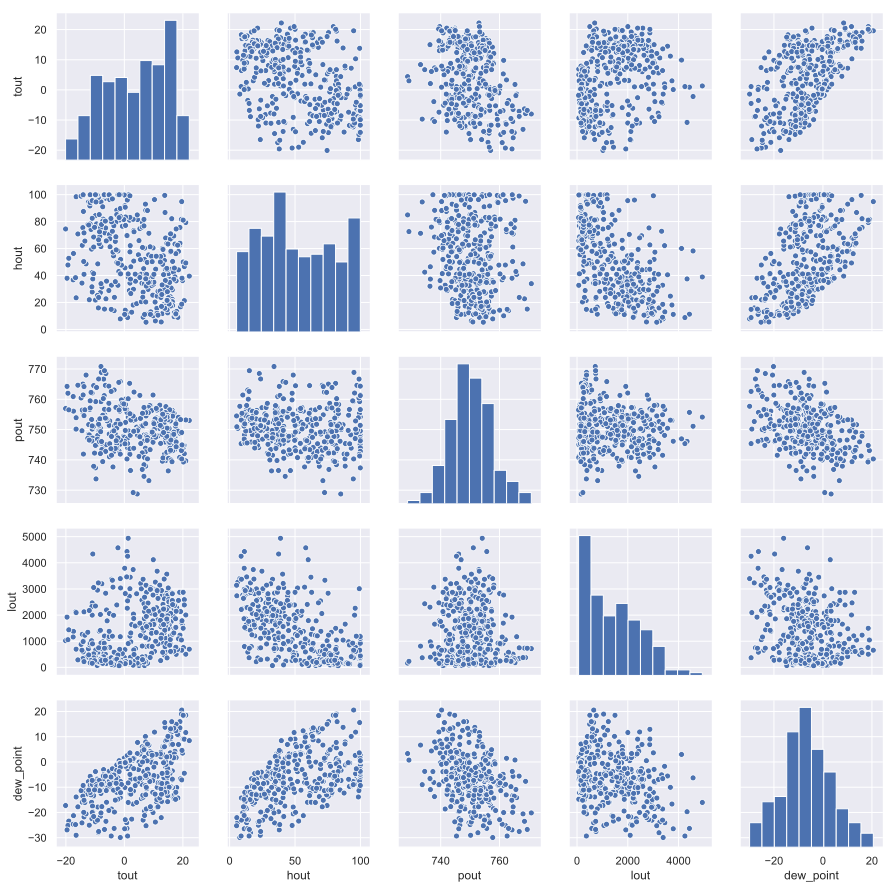

In [38]:
sns.pairplot(X)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [41]:
from sklearn.decomposition import KernelPCA

In [42]:
# ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']
# оставляем первые две компоненты
pca = KernelPCA(n_components = 2, random_state = 0, kernel='linear').fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [43]:
X_train_pca = pd.DataFrame({'1_pca':X_train_pca[:, 0], '2_pca':X_train_pca[:, 1]})

In [44]:
days_below_zero['1_pca'] = X_train_pca['1_pca']
days_below_zero['2_pca'] = X_train_pca['2_pca']

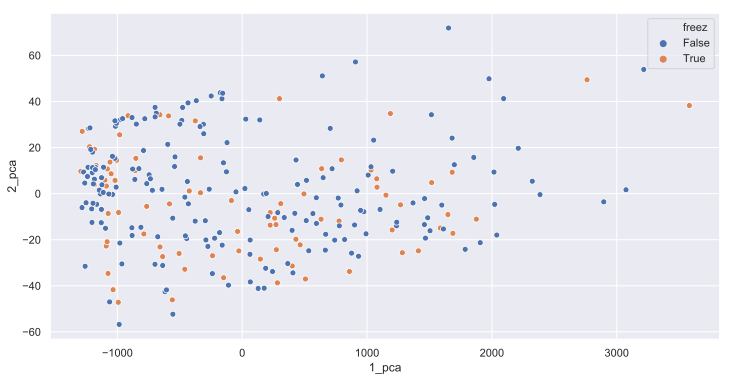

In [45]:
sns.set(rc={'figure.figsize':(12, 6)})
sns.scatterplot(x='1_pca', y='2_pca', data=days_below_zero, hue='freez')

In [120]:
from sklearn.ensemble import RandomForestClassifier
# подбор оптимальных параметров с помощью сетки параметров и кросс-валидации
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [140]:
# попробуем применить Случайный лес для классификации будет ли мороз ночью
# набор фичей используем как есть
rf = RandomForestClassifier(random_state=0)
parametrs = {'n_estimators':[10, 20, 30, 40, 50], 
             'max_depth':range(1, 11)}
grid_search_cv = RandomizedSearchCV(rf, parametrs, cv=5, iid=True)
grid_search_cv.fit(X_train, y_train)
best_rf = grid_search_cv.best_estimator_

In [141]:
grid_search_cv.best_params_

{'n_estimators': 20, 'max_depth': 6}

In [142]:
scores_without_pca = best_rf.score(X_test, y_test)

In [143]:
scores_without_pca

1.0

In [144]:
feature = pd.DataFrame({'feature':X_train.columns, 'importance':best_rf.feature_importances_})\
            .sort_values(by='importance', ascending=False)

In [145]:
feature.head()

,feature,importance
0,tout,0.715328
4,dew_point,0.106714
1,hout,0.103543
3,lout,0.056836
2,pout,0.017579


In [155]:
best_rf.predict(pd.DataFrame({'tout':[10], 
                             'hout':[50], 
                             'pout':[730], 
                             'lout':[567], 
                             'dew_point':[4.5]}))

array([False])